## 1. Importing libraries

In [1]:
pip install fancyimpute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.7 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29898 sha256=0f2150073ace2bbb165f6b1781f2657b1bd612f5d0be009ded63e768dc8764fc
  Stored in directory: /root/.cache/pip/wheels/f9/fc/6a/b0406b906bce293abe23c3b6da5a72637d2d04146ef1125a0b
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11352 sha256=0cfa3d2e036173b80d1f3b35847fe6714034fdc8e1884a3933fc69ca8541d52f
  Stored in directory: /root/.cache/pip/wheels/88/c4/be/e232c750d9bc360abf9a5e2cafe0d3e08e3605d2801bb11684
Successfully built fancyimpute knnimpute


In [2]:
pip install impyute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# To supress warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import numpy as np
import pandas as pd
%matplotlib inline
from scipy.io import arff
import missingno as msno 
import fancyimpute
import impyute as impy
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from collections import Counter
from collections import OrderedDict
from imblearn.over_sampling import SMOTE 

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## 2. Importing and organizing the data

<b>Dataset Link:</b>The Dataset can be found at [Polish bankruptcy dataset](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data)

In [4]:
from scipy.io import arff

In [5]:
############################################################
# Loads the 5 raw .arff files into a list
def load_arff_raw_data():
    N=5
    from google.colab import files
    uploaded = files.upload()
    return [arff.loadarff(str(i+1) + 'year.arff') for i in range(N)]

############################################################
# Loads the 5 raw .arff files into pandas dataframes
def load_dataframes():
    return [pd.DataFrame(data_i_year[0]) for data_i_year in load_arff_raw_data()]

############################################################
# Set the column headers from X1 ... X64 and the class label as Y, for all the 5 dataframes.
def set_new_headers(dataframes):
    cols = ['X' + str(i+1) for i in range(len(dataframes[0].columns)-1)]
    cols.append('Y')
    for df in dataframes:
        df.columns = cols

############################################################
# dataframes is the list of pandas dataframes for the 5 year datafiles.  
dataframes = load_dataframes()

# Set the new headers for the dataframes. The new headers will have the renamed set of feature (X1 to X64)
set_new_headers(dataframes)    

# print the first 5 rows of a dataset 'year1'
dataframes[0].head()

Saving 5year.arff to 5year.arff
Saving 4year.arff to 4year.arff
Saving 3year.arff to 3year.arff
Saving 2year.arff to 2year.arff
Saving 1year.arff to 1year.arff


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [6]:
dataframes[0].dtypes

X1     float64
X2     float64
X3     float64
X4     float64
X5     float64
        ...   
X61    float64
X62    float64
X63    float64
X64    float64
Y       object
Length: 65, dtype: object

In [7]:
# Convert the dtypes of all the columns (other than the class label columns) to float.
def convert_columns_type_float(dfs):
    for i in range(5):
        index = 1
        while(index<=63):
            colname = dfs[i].columns[index]
            col = getattr(dfs[i], colname)
            dfs[i][colname] = col.astype(float)
            index+=1
            
convert_columns_type_float(dataframes)            

In [8]:
# The class labels for all the dataframes are originally in object type.
# Convert them to int types
def convert_class_label_type_int(dfs):
    for i in range(len(dfs)):
        col = getattr(dfs[i], 'Y')
        dfs[i]['Y'] = col.astype(int)
        
convert_class_label_type_int(dataframes)

In [9]:
dataframes[0].dtypes

X1     float64
X2     float64
X3     float64
X4     float64
X5     float64
        ...   
X61    float64
X62    float64
X63    float64
X64    float64
Y        int64
Length: 65, dtype: object

## 3. Data Analysis and Preprocessing

In [10]:
############################################################
# Get Clean dataframes by dropping all the rows which have missing values
def drop_nan_rows(dataframes, verbose=False):
    clean_dataframes = [df.dropna(axis=0, how='any') for df in dataframes]
    if verbose:
        for i in range(len(dataframes)):
            print(str(i+1)+'year:','Original Length=', len(dataframes[i]), '\tCleaned Length=', len(clean_dataframes[i]), '\tMissing Data=', len(dataframes[i])-len(clean_dataframes[i]))
    return clean_dataframes

# Doing a quick analysis of how many missing values are there in each of the 5 dataframes
nan_dropped_dataframes = drop_nan_rows(dataframes, verbose=True)

1year: Original Length= 7027 	Cleaned Length= 3194 	Missing Data= 3833
2year: Original Length= 10173 	Cleaned Length= 4088 	Missing Data= 6085
3year: Original Length= 10503 	Cleaned Length= 4885 	Missing Data= 5618
4year: Original Length= 9792 	Cleaned Length= 4769 	Missing Data= 5023
5year: Original Length= 5910 	Cleaned Length= 3031 	Missing Data= 2879


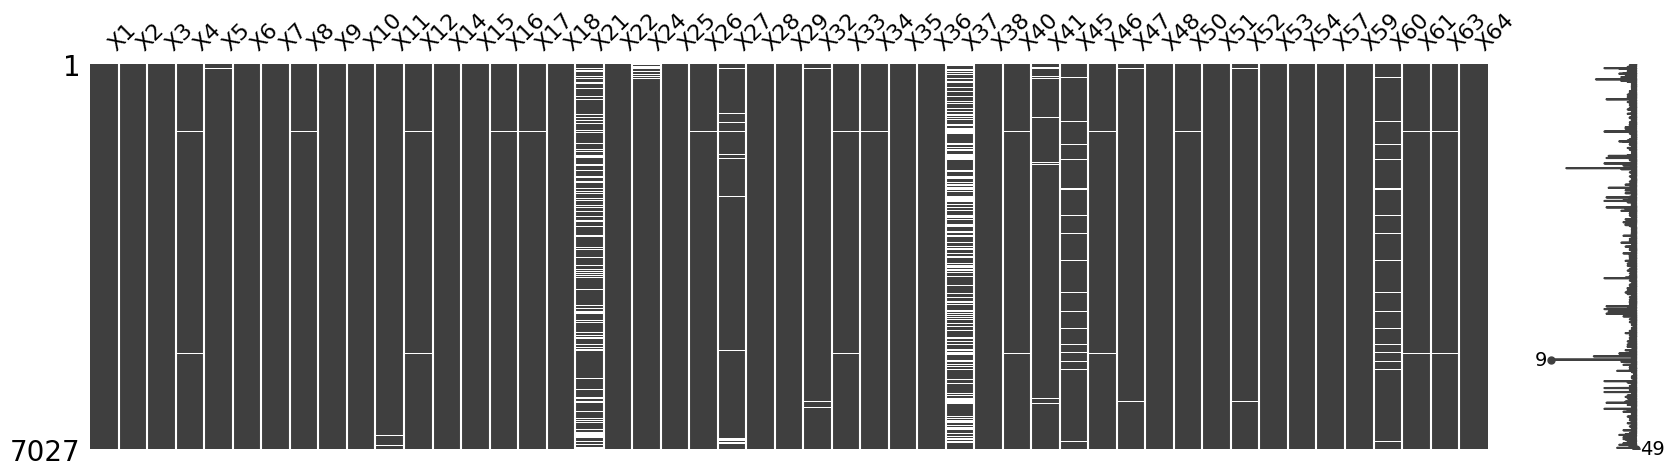

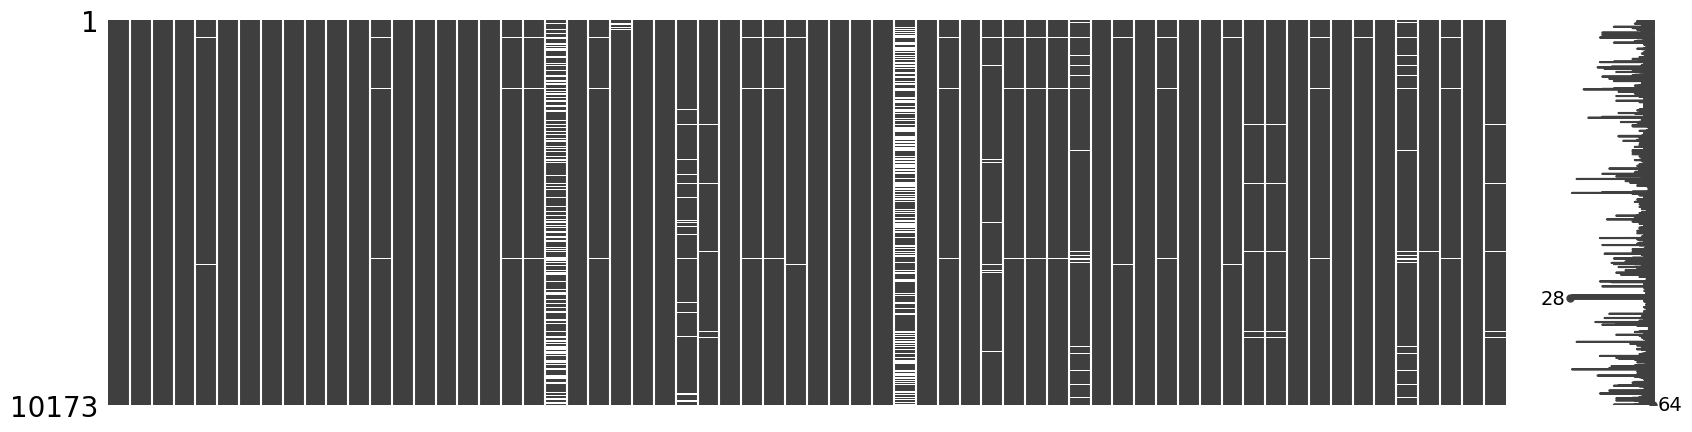

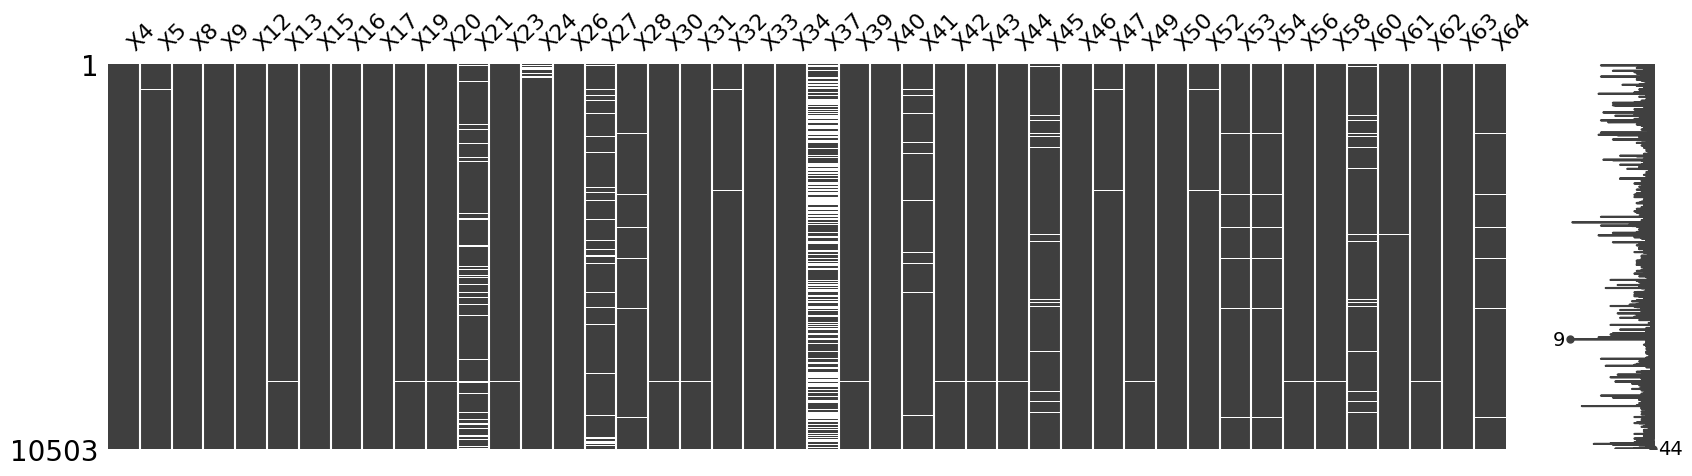

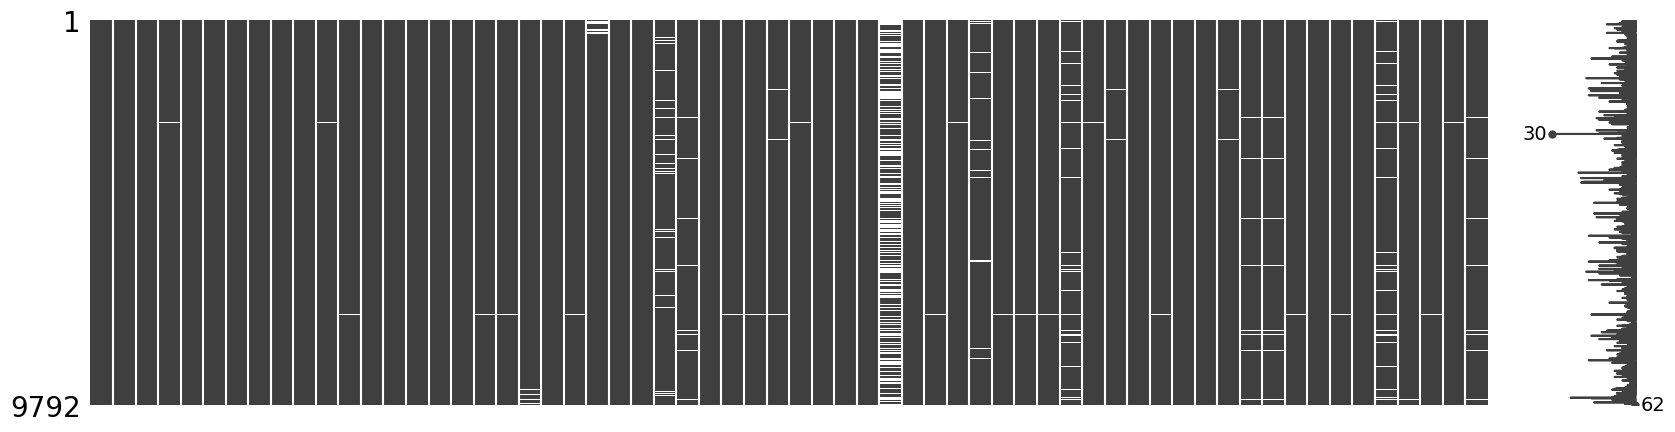

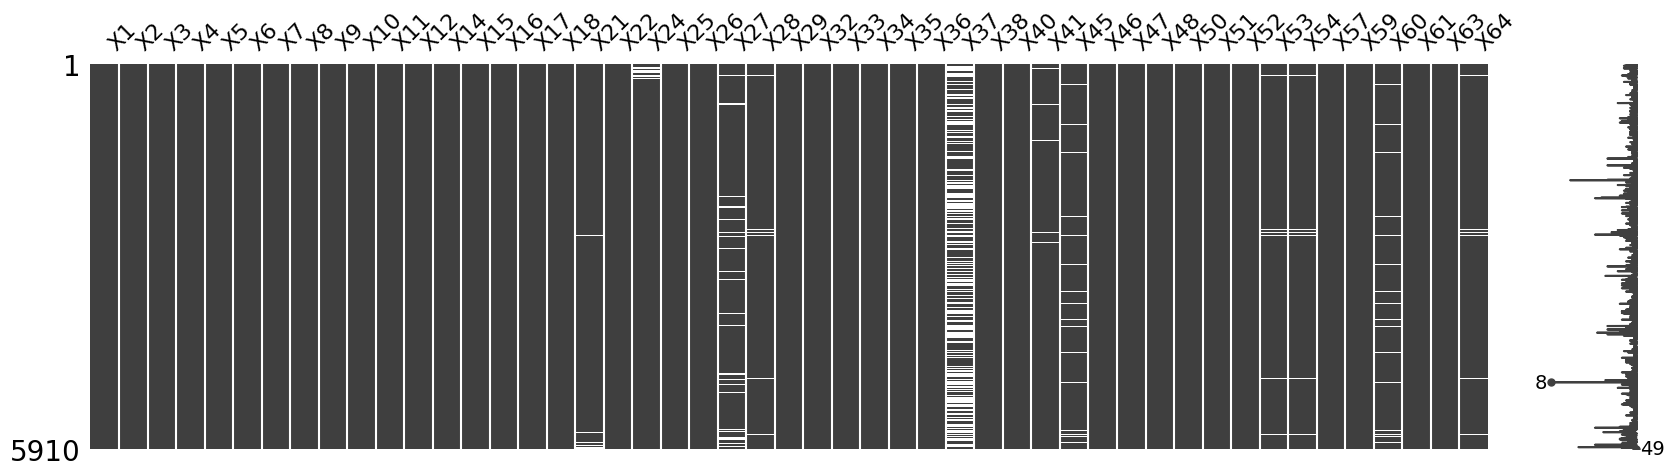

In [11]:
# generate the sparsity matrix (figure) for all the dataframes
def generate_sparsity_matrix(dfs):
    for i in range(5):
        missing_df_i = dfs[i].columns[dfs[i].isnull().any()].tolist()
        msno.matrix(dfs[i][missing_df_i], figsize=(20,5))

generate_sparsity_matrix(dataframes)

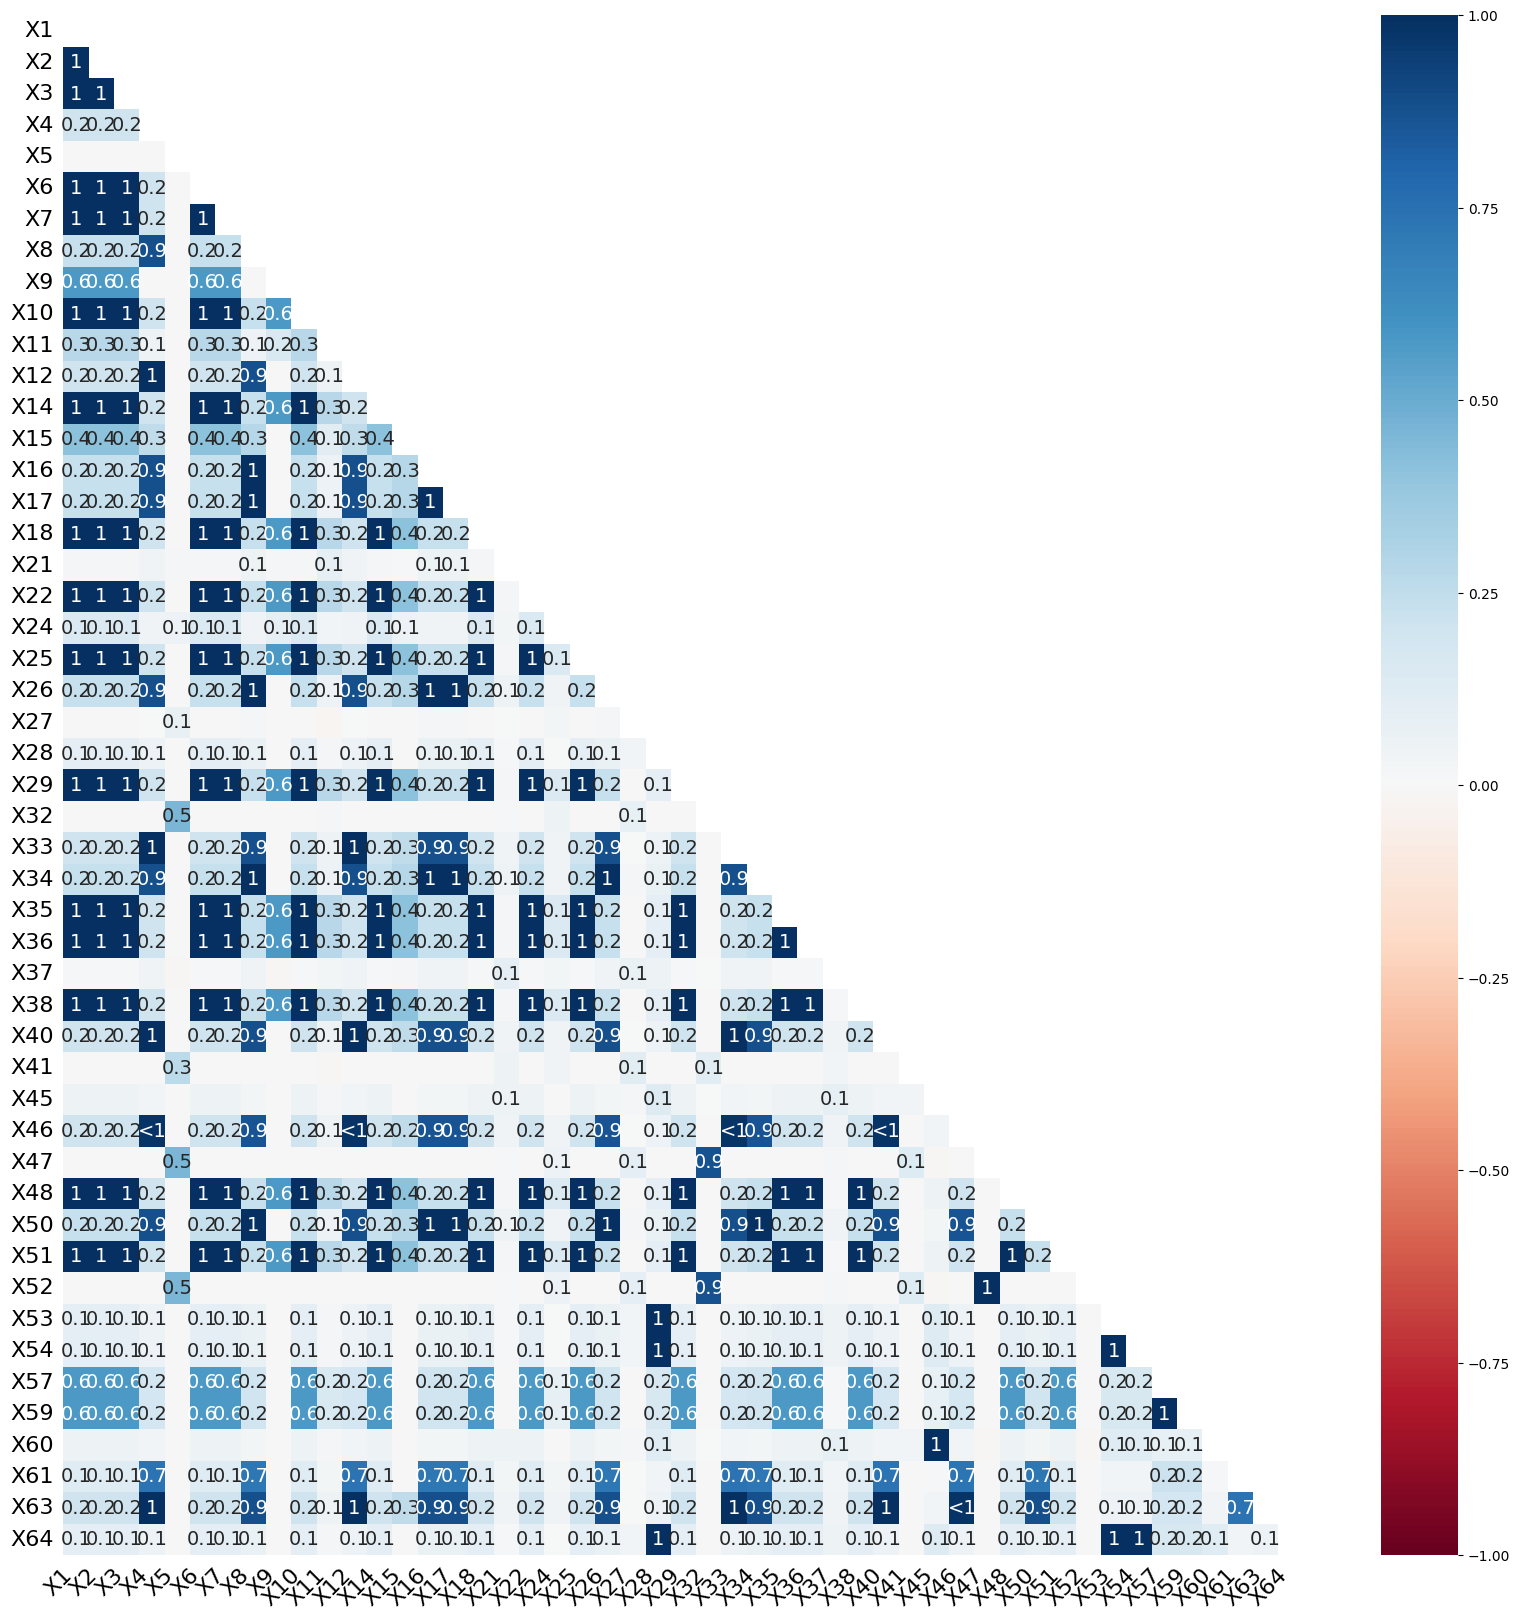

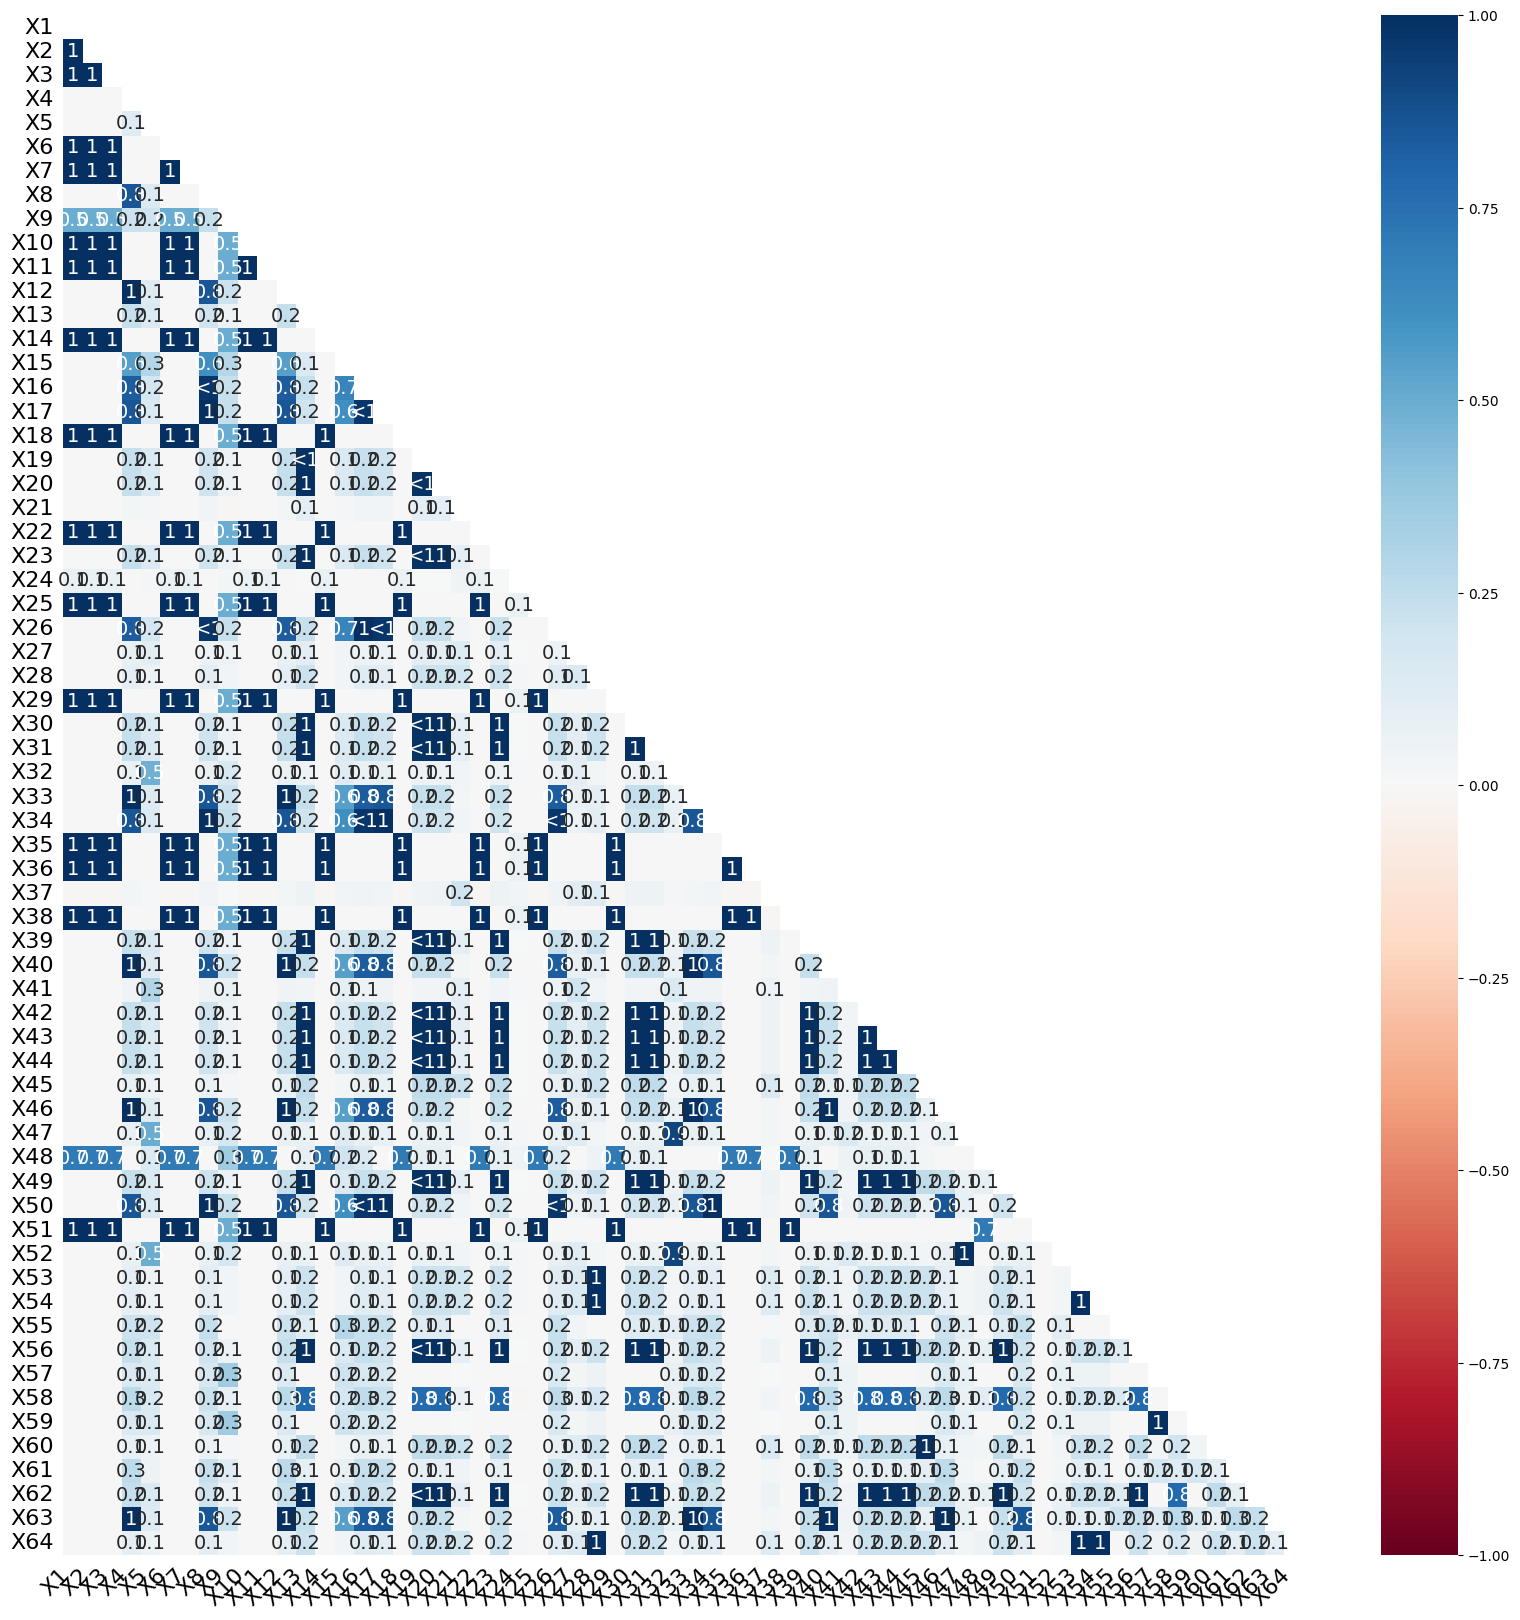

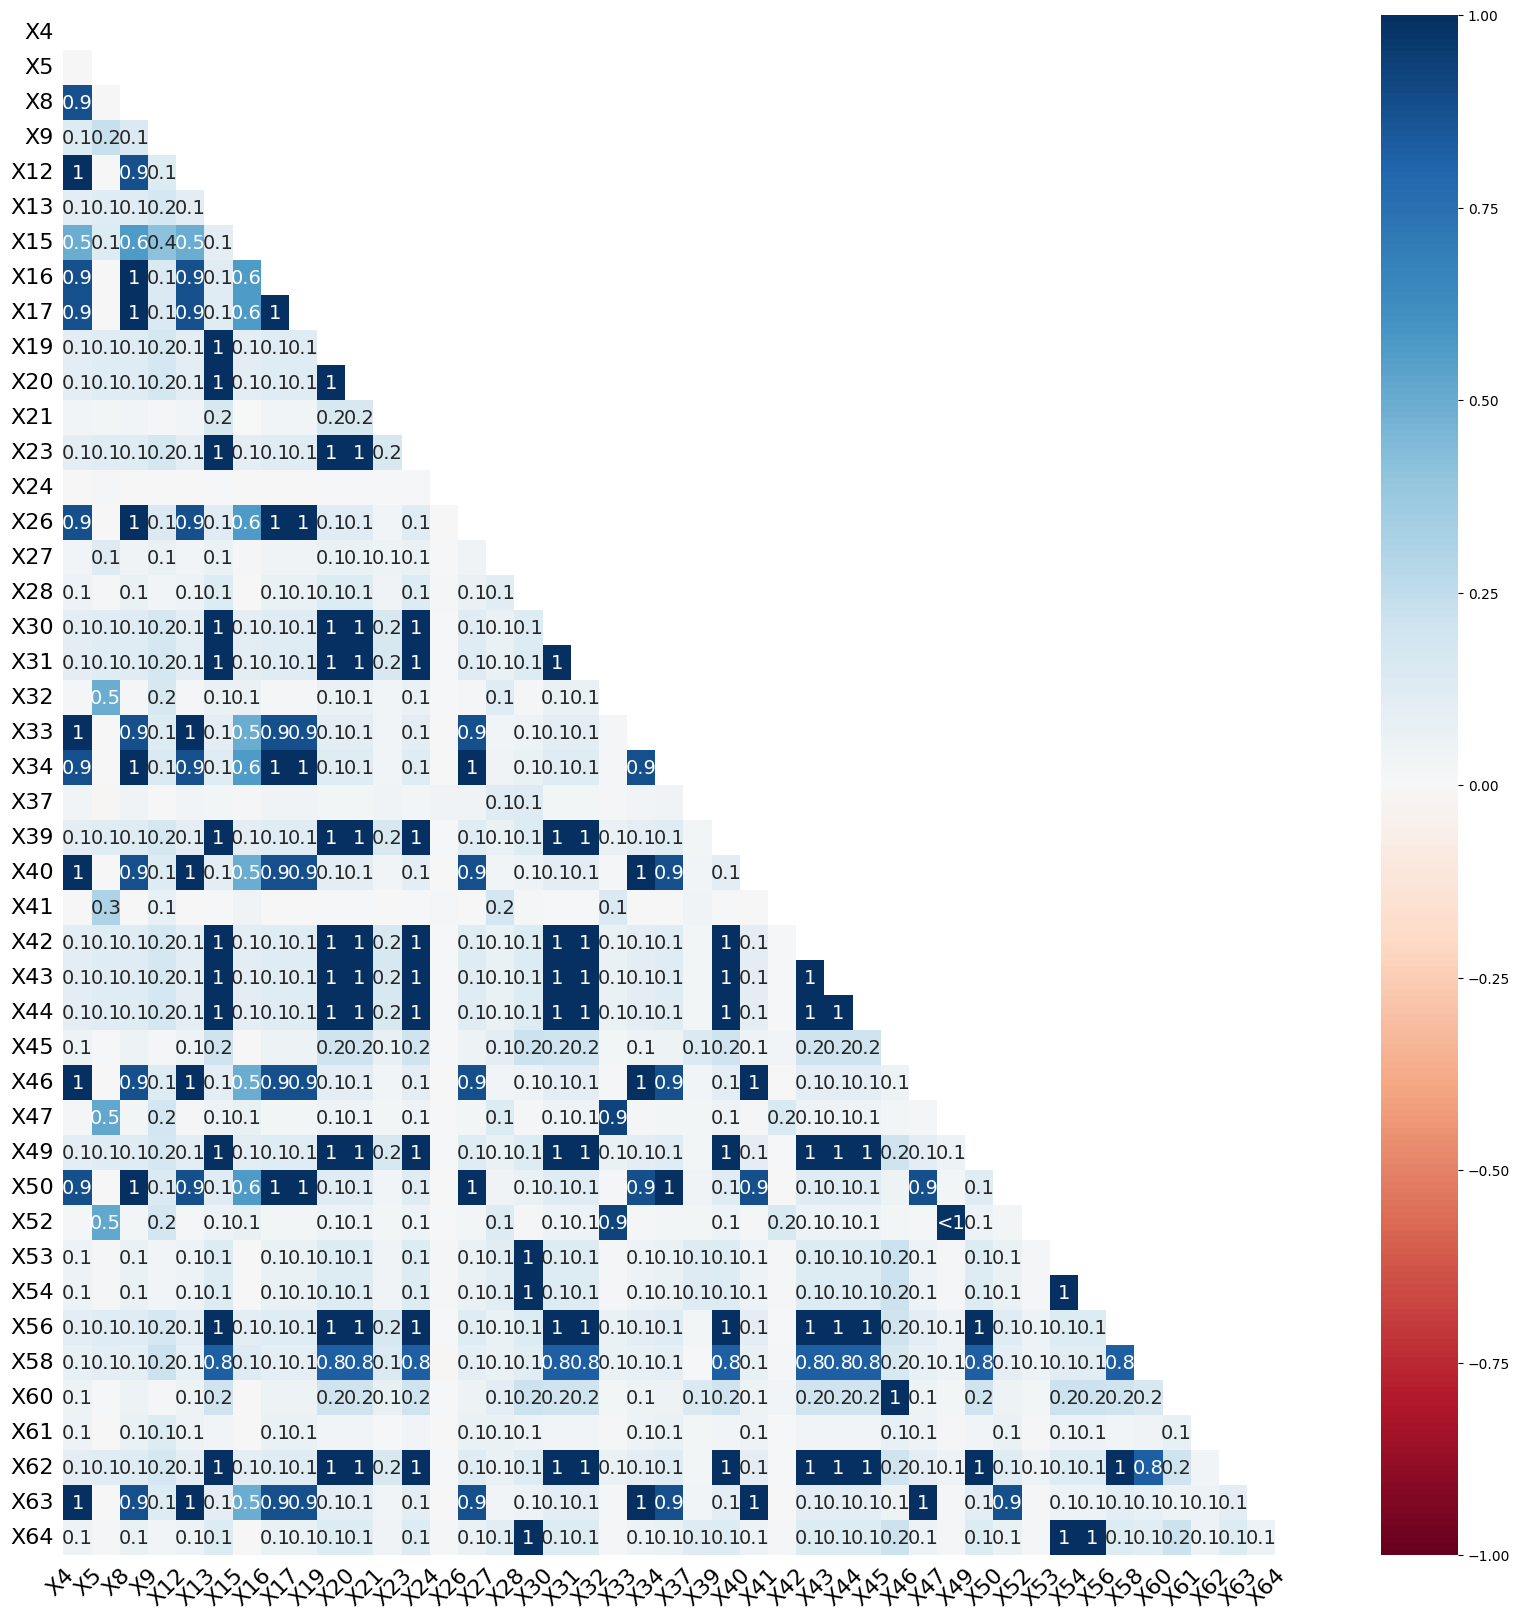

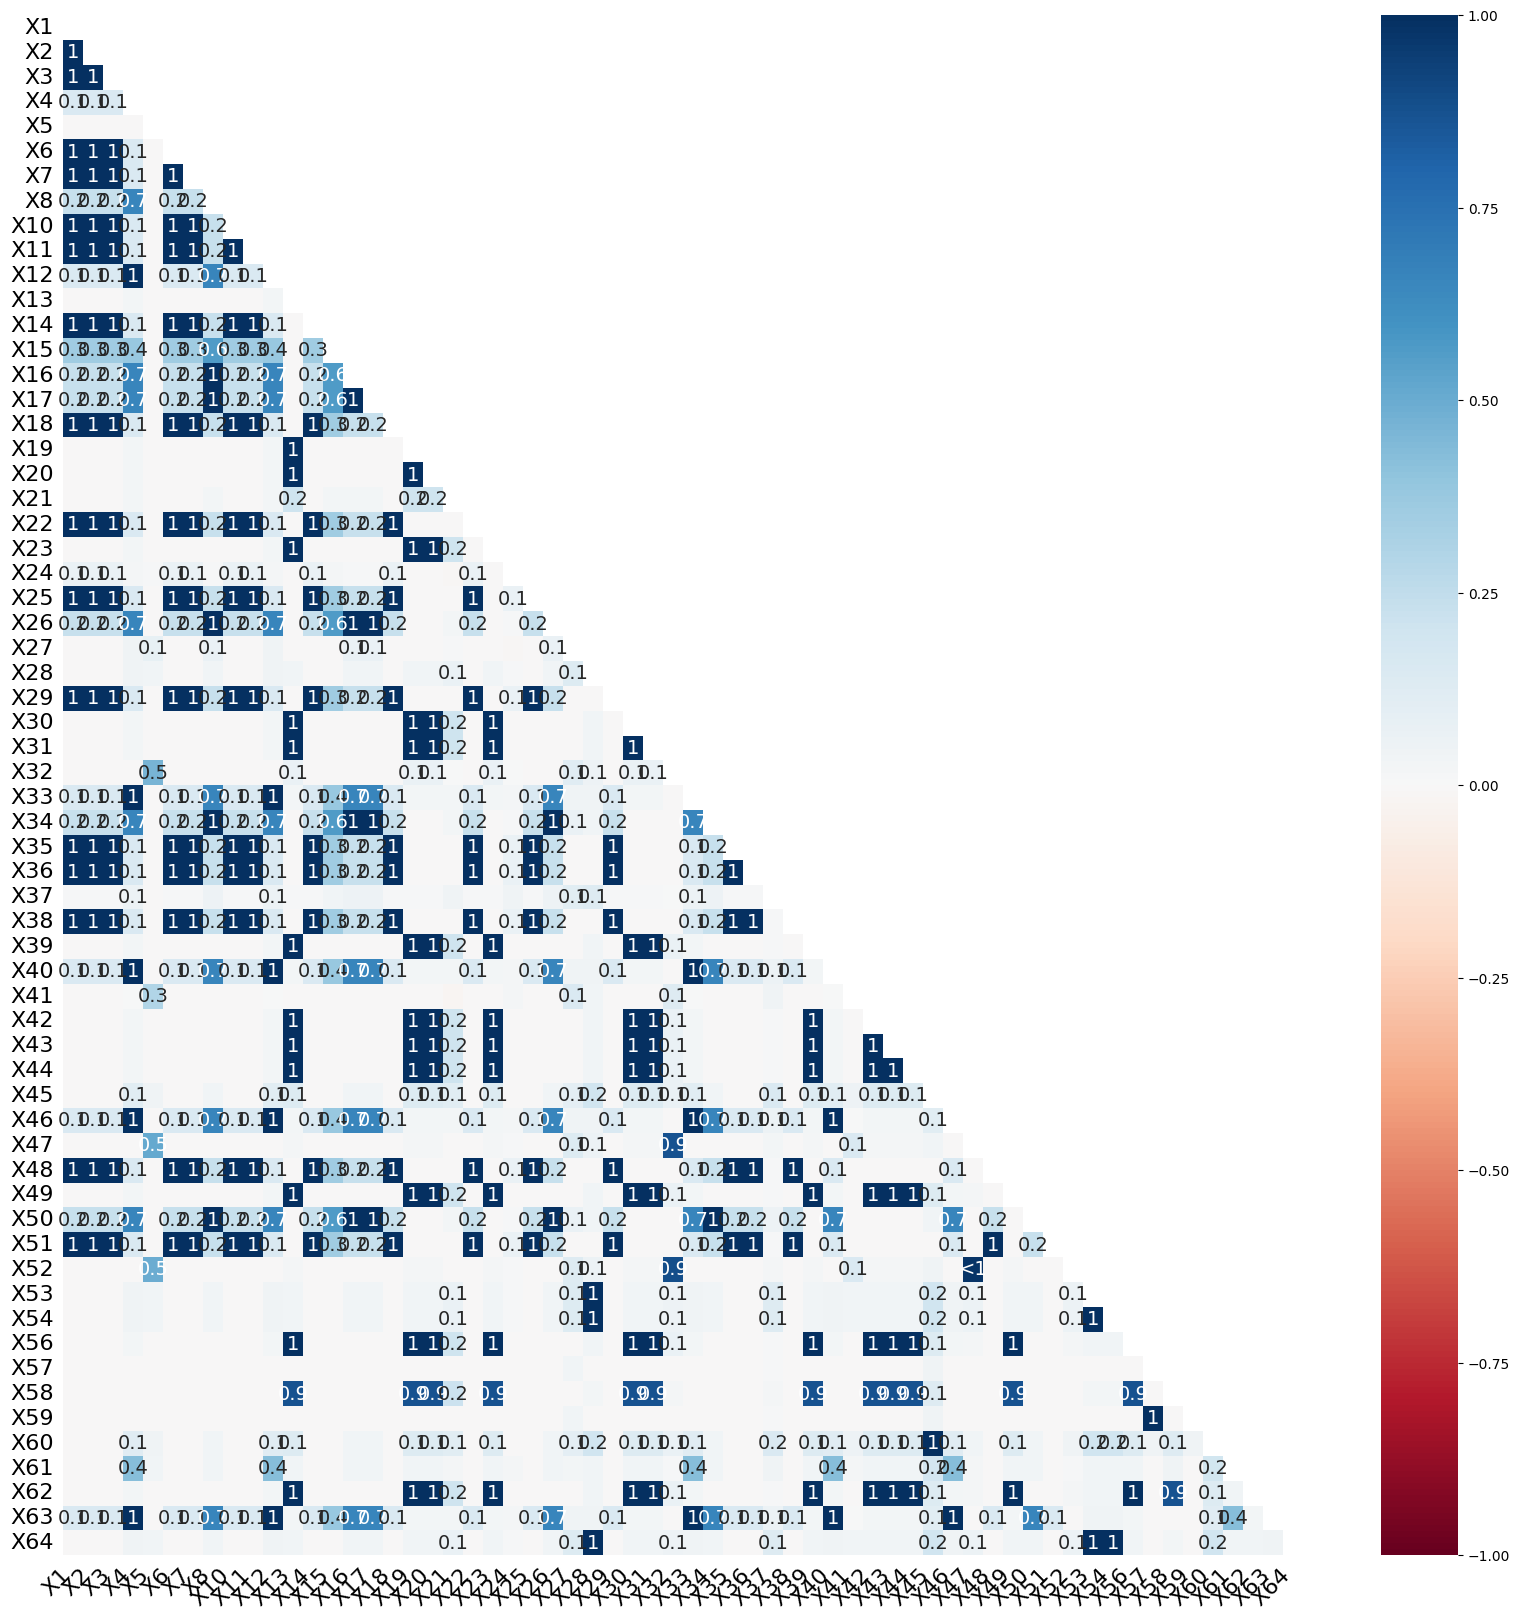

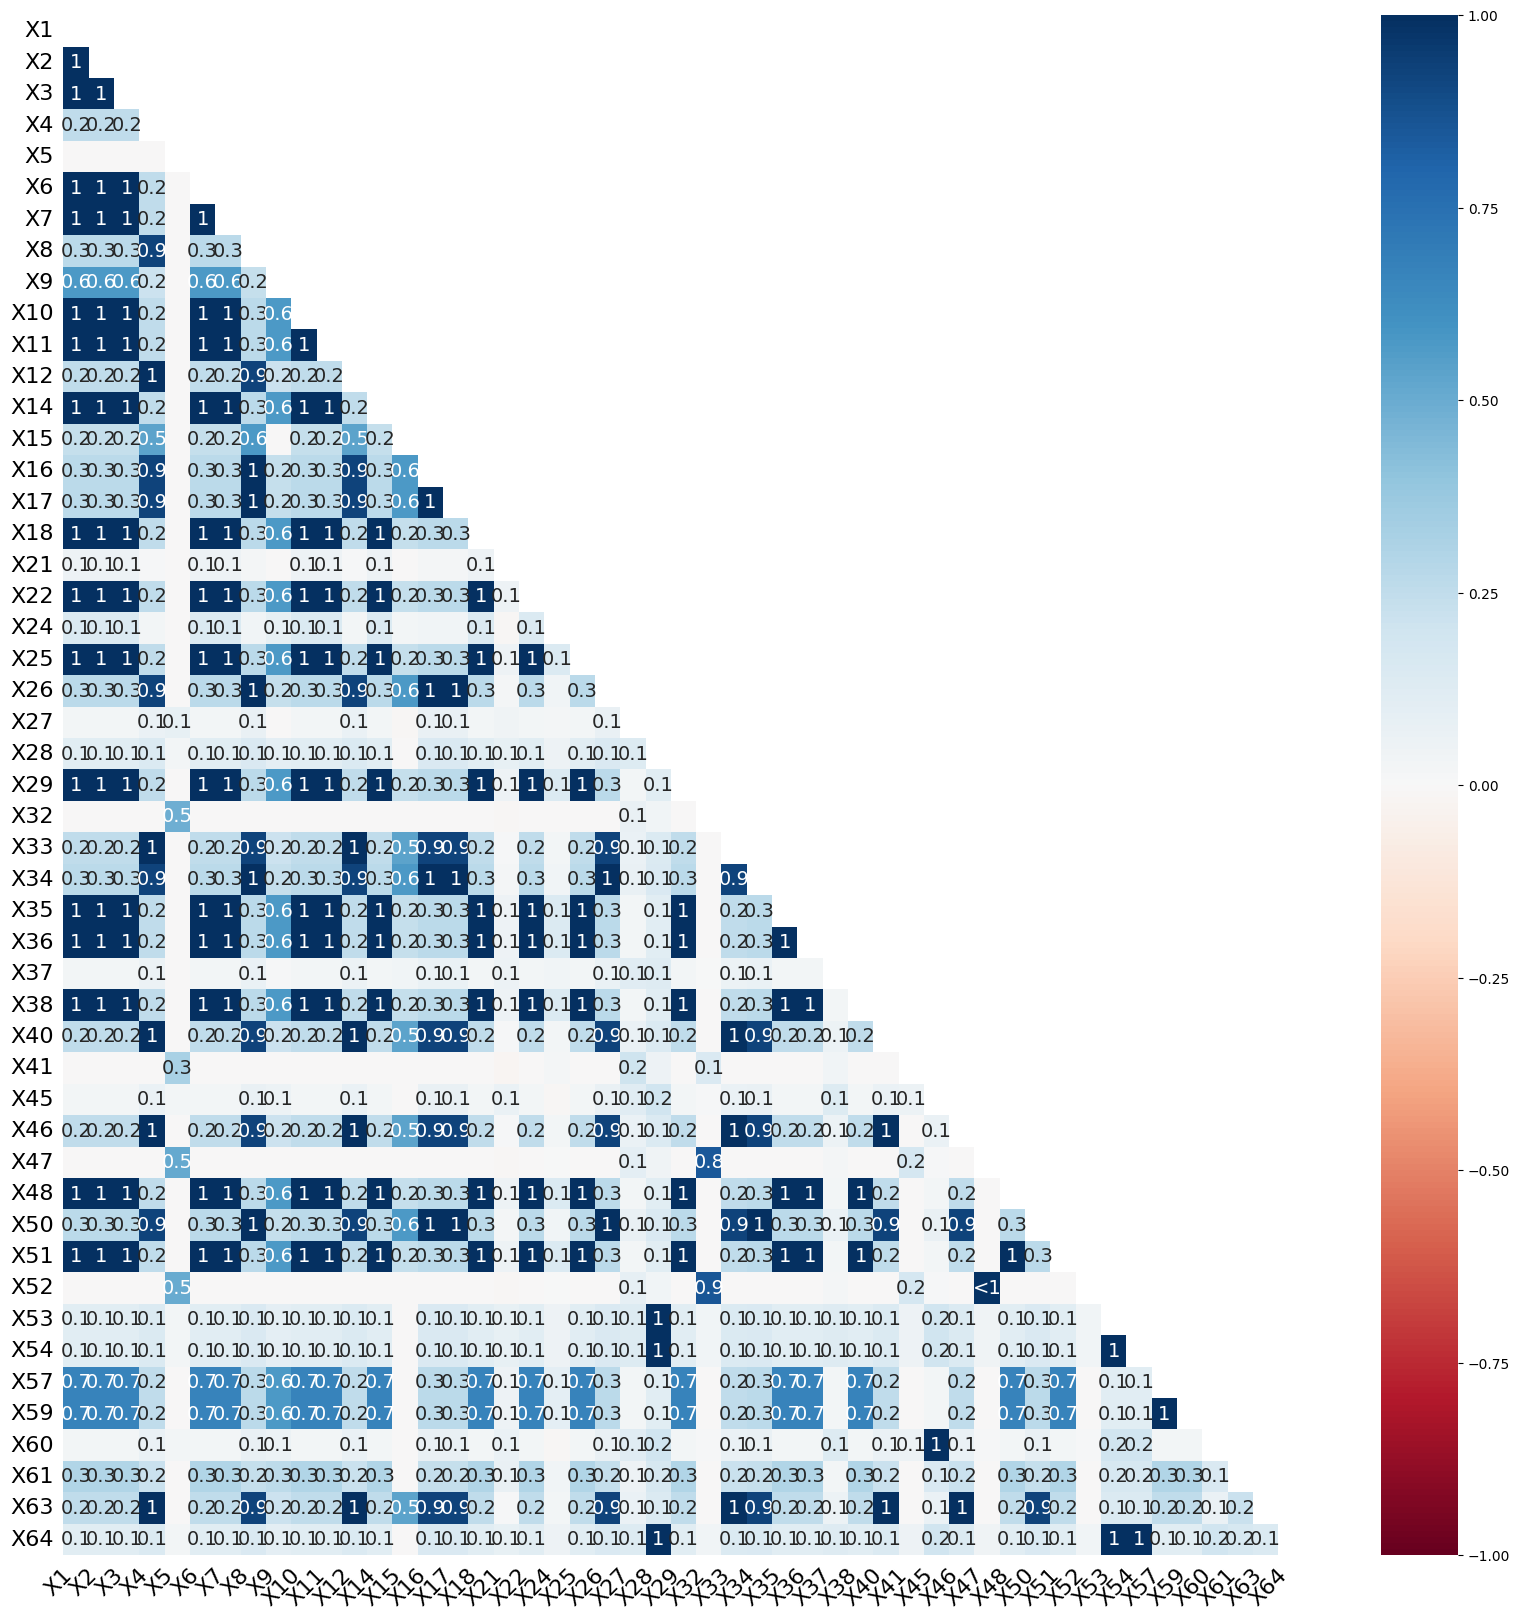

In [12]:
# generate the heatmap for all the dataframes
def generate_heatmap(dfs):
    for i in range(5):
        missing_df_i = dfs[i].columns[dfs[i].isnull().any()].tolist()
        msno.heatmap(dfs[i][missing_df_i], figsize=(20,20))
        
generate_heatmap(dataframes)        

#### 3.B.a Mean Imputation

In [13]:
def perform_mean_imputation(dfs):
    # Construct an imputer with strategy as 'mean', to mean-impute along the columns
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean',fill_value=None, verbose=0, copy=True)
    mean_imputed_dfs = [pd.DataFrame(imputer.fit_transform(df)) for df in dfs]
    for i in range(len(dfs)):
        mean_imputed_dfs[i].columns = dfs[i].columns   
    return mean_imputed_dfs

mean_imputed_dataframes = perform_mean_imputation(dataframes)

#### 3.B.b k-Nearest Neighbors (k-NN) Imputation

In [14]:
def perform_knn_imputation(dfs):
    knn_imputed_datasets = [fancyimpute.KNN(k=100,verbose=True).fit_transform(dfs[i]) for i in range(len(dfs))]
    return [pd.DataFrame(data=knn_imputed_datasets[i]) for i in range(len(dfs))]
    
knn_imputed_dataframes = perform_knn_imputation(dataframes)
set_new_headers(knn_imputed_dataframes)

Imputing row 1/7027 with 0 missing, elapsed time: 26.179
Imputing row 101/7027 with 1 missing, elapsed time: 26.187
Imputing row 201/7027 with 2 missing, elapsed time: 26.200
Imputing row 301/7027 with 0 missing, elapsed time: 26.211
Imputing row 401/7027 with 0 missing, elapsed time: 26.219
Imputing row 501/7027 with 1 missing, elapsed time: 26.227
Imputing row 601/7027 with 1 missing, elapsed time: 26.233
Imputing row 701/7027 with 1 missing, elapsed time: 26.240
Imputing row 801/7027 with 0 missing, elapsed time: 26.246
Imputing row 901/7027 with 0 missing, elapsed time: 26.253
Imputing row 1001/7027 with 1 missing, elapsed time: 26.260
Imputing row 1101/7027 with 1 missing, elapsed time: 26.267
Imputing row 1201/7027 with 3 missing, elapsed time: 26.274
Imputing row 1301/7027 with 1 missing, elapsed time: 26.282
Imputing row 1401/7027 with 1 missing, elapsed time: 26.288
Imputing row 1501/7027 with 1 missing, elapsed time: 26.295
Imputing row 1601/7027 with 1 missing, elapsed time:

#### 3.B.c Expectation-Maximization (EM) Imputation

In [15]:
def perform_EM_imputation(dfs):
    em_imputed_datasets = [impy.imputation.cs.em(dfs[i].values, loops=50, dtype='cont') for i in range(len(dfs))]
    return [pd.DataFrame(data=em_imputed_datasets[i]) for i in range(len(dfs))]

em_imputed_dataframes = perform_EM_imputation(dataframes)
set_new_headers(em_imputed_dataframes)

In [16]:
imputed_dataframes_dictionary = OrderedDict()
imputed_dataframes_dictionary['Mean'] = mean_imputed_dataframes
imputed_dataframes_dictionary['k-NN'] = knn_imputed_dataframes
imputed_dataframes_dictionary['EM'] = em_imputed_dataframes

In [17]:
def check_data_imbalance(dfs):
    for i in range(len(dfs)):
        print('Dataset: '+str(i+1)+'year')
        print(dfs[i].groupby('Y').size())
        minority_percent = (dfs[i]['Y'].tolist().count(1) / len(dfs[i]['Y'].tolist()))*100
        print('Minority (label 1) percentage: '+  str(minority_percent) + '%')
        print('-'*64)
        
check_data_imbalance(dataframes)

Dataset: 1year
Y
0    6756
1     271
dtype: int64
Minority (label 1) percentage: 3.856553294435748%
----------------------------------------------------------------
Dataset: 2year
Y
0    9773
1     400
dtype: int64
Minority (label 1) percentage: 3.931976801336872%
----------------------------------------------------------------
Dataset: 3year
Y
0    10008
1      495
dtype: int64
Minority (label 1) percentage: 4.712939160239932%
----------------------------------------------------------------
Dataset: 4year
Y
0    9277
1     515
dtype: int64
Minority (label 1) percentage: 5.259395424836601%
----------------------------------------------------------------
Dataset: 5year
Y
0    5500
1     410
dtype: int64
Minority (label 1) percentage: 6.937394247038917%
----------------------------------------------------------------


#### 3.C.a Oversampling with SMOTE (Synthetic Minority Over Sampling Technique)

In [18]:
# Split the features and labels into separate dataframes for all the original dataframes
def split_dataframes_features_labels(dfs):
    feature_dfs = [dfs[i].iloc[:,0:64] for i in range(len(dfs))]
    label_dfs = [dfs[i].iloc[:,64] for i in range(len(dfs))]
    return feature_dfs, label_dfs

# Performs the SMOTE oversampling fro given dataframes.
def oversample_data_SMOTE(dfs, verbose=False):
    smote = SMOTE(sampling_strategy='auto' , random_state=42, k_neighbors=10)
    #Split the features and labels for each dataframe
    feature_dfs, label_dfs = split_dataframes_features_labels(dfs)
    resampled_feature_arrays = []
    resampled_label_arrays = []
    for i in range(len(dfs)):
        if verbose: print('Dataset: ' + str(i+1) + 'year:')
        if verbose: print('Original dataset shape {}'.format(Counter(label_dfs[i])))
        dfi_features_res, dfi_label_res = smote.fit_resample(feature_dfs[i], label_dfs[i])
        if verbose: print('Resampled dataset shape {}\n'.format(Counter(dfi_label_res)))
        # Append the resampled feature and label arrays of ith dataframe to their respective list of arrays    
        resampled_feature_arrays.append(dfi_features_res)
        resampled_label_arrays.append(dfi_label_res)        
    return resampled_feature_arrays, resampled_label_arrays

# Utility Function to convert the arrays of features and labels to pandas dataframes, and then join them.
# Also re-assign the columns headers.
def restructure_arrays_to_dataframes(feature_arrays, label_arrays):
    resampled_dfs = []
    for i in range(len(feature_arrays)):
        feature_df = pd.DataFrame(data=feature_arrays[i])
        label_df = pd.DataFrame(data=label_arrays[i])
        # Must set the column header for label_df, otherwise it wont join with feature_df, as columns overlap (with col names '0')
        label_df.columns=['Y'] 
        resampled_dfs.append(feature_df.join(label_df))
    # re-assign the column headers for features and labels    
    set_new_headers(resampled_dfs)    
    return resampled_dfs

# Perform SMOTE oversampling on all the imputed dataframes, and return them in a dictionary.
def perform_oversampling_on_imputed_dataframes(df_dict):
    imputed_oversampled_dataframes_dictionary = OrderedDict()
    for key,dfs in df_dict.items():
        print('SMOTE Oversampling for ' + key + ' imputed dataframes\n')
        smote_feature_arrays, smote_label_arrays = oversample_data_SMOTE(dfs, verbose=True)
        oversampled_dataframes = restructure_arrays_to_dataframes(smote_feature_arrays, smote_label_arrays)
        imputed_oversampled_dataframes_dictionary[key] = oversampled_dataframes
        print('-'*100)
    return imputed_oversampled_dataframes_dictionary

imputed_oversampled_dataframes_dictionary = perform_oversampling_on_imputed_dataframes(imputed_dataframes_dictionary)

SMOTE Oversampling for Mean imputed dataframes

Dataset: 1year:
Original dataset shape Counter({0.0: 6756, 1.0: 271})
Resampled dataset shape Counter({0.0: 6756, 1.0: 6756})

Dataset: 2year:
Original dataset shape Counter({0.0: 9773, 1.0: 400})
Resampled dataset shape Counter({0.0: 9773, 1.0: 9773})

Dataset: 3year:
Original dataset shape Counter({0.0: 10008, 1.0: 495})
Resampled dataset shape Counter({0.0: 10008, 1.0: 10008})

Dataset: 4year:
Original dataset shape Counter({0.0: 9277, 1.0: 515})
Resampled dataset shape Counter({0.0: 9277, 1.0: 9277})

Dataset: 5year:
Original dataset shape Counter({0.0: 5500, 1.0: 410})
Resampled dataset shape Counter({0.0: 5500, 1.0: 5500})

----------------------------------------------------------------------------------------------------
SMOTE Oversampling for k-NN imputed dataframes

Dataset: 1year:
Original dataset shape Counter({0.0: 6756, 1.0: 271})
Resampled dataset shape Counter({0.0: 6756, 1.0: 6756})

Dataset: 2year:
Original dataset shape

## 4. Data Modeling: Building Classification Models

### 4.A K-Fold Cross Validation

In [19]:
def prepare_kfold_cv_data(k, X, y, verbose=False):
    X = X.values
    y = y.values
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for train_index, test_index in kf.split(X):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test

### 4.B MODELS

### 4.B.a Gaussian Naive Bayes classifier

In [20]:
# Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

### 4.B.b Logistic Regression classifier

In [21]:
# Logistic Regression classifier
lr_classifier = LogisticRegression(C=0.01,penalty = 'l1',solver='liblinear', random_state = 0)

### 4.B.c Decision Tree Classifier

In [22]:
# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

### 4.B.d Random Forest Classifier

In [23]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')

### 4.B.e Extreme Gradient Boosting Classifier

In [24]:
# eXtreme Gradient Boosting Classifier (XGBClassifier)
xgb_classifier = XGBClassifier()

In [25]:
# creating a dictionary of models
models_dictionary = OrderedDict()

models_dictionary['Gaussian Naive Bayes'] = gnb_classifier
models_dictionary['Logistic Regression'] = lr_classifier
models_dictionary['Decision Tree'] = dt_classifier
models_dictionary['Extreme Gradient Boosting'] = xgb_classifier
models_dictionary['Random Forest'] = rf_classifier

In [26]:
# perform data modeling
def perform_data_modeling(_models_, _imputers_, verbose=False, k_folds=5):
    
    # 5 Models
    # 3 Imputers
    # 5 datasets (for 5 years)
    # 3 metrics, averaged over all the K-Folds
    model_results = OrderedDict()
    
    # Iterate over the models
    for model_name, clf in _models_.items():
        if verbose: print("-"*120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()
        
        # Iterate over the different imputed_data mechanisms (Mean, k-NN, EM, MICE)
        for imputer_name, dataframes_list in _imputers_.items():
            if verbose: print('\tImputer Technique: ' + '\033[1m' + imputer_name + '\033[0m')
            
            # call the split_dataframes_features_labels function to get a list of features and labels for all the dataframes
            feature_dfs, label_dfs = split_dataframes_features_labels(dataframes_list)            
            
            year_results = OrderedDict()
            
            # Iterate over dataframe_list individually
            for df_index in range(len(dataframes_list)):
                if verbose: print('\t\tDataset: ' + '\033[1m' + str(df_index+1) + 'year' + '\033[0m')
                
                # Calling the 'prepare_kfold_cv_data' returns lists of features and labels 
                # for train and test sets respectively.
                # The number of items in the list is equal to k_folds
                X_train_list, y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(k_folds, feature_dfs[df_index], label_dfs[df_index], verbose)
                
                metrics_results = OrderedDict()
                accuracy_list = np.zeros([k_folds])
                precision_list = np.zeros([k_folds,2])
                recall_list = np.zeros([k_folds,2])
                TN_list = np.zeros([k_folds])
                FP_list = np.zeros([k_folds])
                FN_list = np.zeros([k_folds])
                TP_list = np.zeros([k_folds])                
                
                # Iterate over all the k-folds
                for k_index in range(k_folds):
                    X_train = X_train_list[k_index]
                    y_train = y_train_list[k_index]
                    X_test = X_test_list[k_index]
                    y_test = y_test_list[k_index]
                    
                    # Fit the model and 
                    clf = clf.fit(X_train, y_train)
                    y_test_predicted = clf.predict(X_test)
                    
                    #code for calculating accuracy 
                    _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
                    accuracy_list[k_index] = _accuracy_
                    
                    #code for calculating recall 
                    _recalls_ = recall_score(y_test, y_test_predicted, average=None)
                    recall_list[k_index] = _recalls_
                    
                    #code for calculating precision 
                    _precisions_ = precision_score(y_test, y_test_predicted, average=None)
                    precision_list[k_index] = _precisions_
                    
                
                # creating a metrics dictionary
                metrics_results['Accuracy'] = np.mean(accuracy_list)
                metrics_results['Precisions'] = np.mean(precision_list, axis=0)
                metrics_results['Recalls'] = np.mean(recall_list, axis=0)
                metrics_results['TN'] = np.mean(TN_list)
                metrics_results['FP'] = np.mean(FP_list)
                metrics_results['FN'] = np.mean(FN_list)
                metrics_results['TP'] = np.mean(TP_list)
                
                if verbose:
                    print('\t\t\tAccuracy:', metrics_results['Accuracy'])
                    print('\t\t\tPrecision:', metrics_results['Precisions'])
                    print('\t\t\tRecall:', metrics_results['Recalls'])
                
                year_results[str(df_index+1)+'year'] = metrics_results   
                
            imputer_results[imputer_name] = year_results
            
        model_results[model_name] = imputer_results  
        
    return model_results                

In [27]:
results = perform_data_modeling(models_dictionary, imputed_oversampled_dataframes_dictionary, verbose=True, k_folds=5)

------------------------------------------------------------------------------------------------------------------------ 
 Model: Gaussian Naive Bayes Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.513025305928413
			Precision: [0.75777557 0.50669387]
			Recall: [0.03818726 0.98789271]
		Dataset: 2year
			Accuracy: 0.513097455606087
			Precision: [0.69693339 0.50678232]
			Recall: [0.04616108 0.98006004]
		Dataset: 3year
			Accuracy: 0.5196842502987893
			Precision: [0.74192611 0.51024965]
			Recall: [0.06062917 0.97869307]
		Dataset: 4year
			Accuracy: 0.5121810367807227
			Precision: [0.62025895 0.50641877]
			Recall: [0.06276721 0.96160451]
		Dataset: 5year
			Accuracy: 0.5161818181818182
			Precision: [0.6000262  0.56877141]
			Recall: [0.24508345 0.78762013]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.5150974066427823
			Precision: [0.76898429 0.50776655]
			Recall: [0.0431842  0.98699361]
		Dataset: 2year
			Accuracy: 0.5119208279928475
			Precis

## Model Analysis

### Model Ranking

In [28]:
# model -> imputer -> year
def perform_model_ranking(models, imputers, results):
    column_headers = ['-'] + list(imputers.keys())
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        for imputer_name, imputer_details in model_details.items():
            mean_accuracy = 0
            for year, metrics in imputer_details.items():
                mean_accuracy += metrics['Accuracy']
            mean_accuracy = mean_accuracy/len(imputer_details)
            row.append(mean_accuracy)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

In [29]:
perform_model_ranking(models_dictionary, imputed_oversampled_dataframes_dictionary, results)

,-,Mean,k-NN,EM
0,Gaussian Naive Bayes,0.514834,0.516469,0.514841
1,Logistic Regression,0.715885,0.717098,0.700490
2,Decision Tree,0.929784,0.904210,0.923528
3,Extreme Gradient Boosting,0.989260,0.985345,0.989356
4,Random Forest,0.953704,0.935276,0.945584


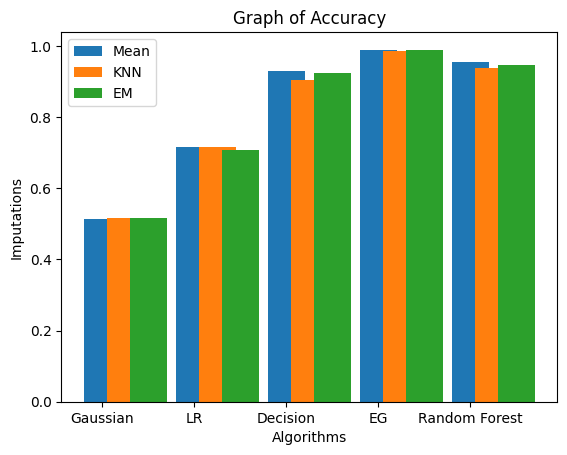

In [30]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Gaussian','LR','Decision','EG', 'Random Forest']
mean_y= [0.514834,0.715885,0.929784,0.989260,0.953388]
knn_y= [0.516469,0.717196,0.904210,0.985345,0.937045]
em_y=[0.515161,0.706942,0.923568,0.989093,0.945997]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis,mean_y, 0.4, label = 'Mean')
plt.bar(X_axis + 0.25,knn_y, 0.4, label = 'KNN')
plt.bar(X_axis + 0.5,em_y, 0.4, label = 'EM')

  
plt.xticks(X_axis, X)
plt.xlabel("Algorithms")
plt.ylabel("Imputations")
plt.title("Graph of Accuracy")
plt.legend()
plt.show()

## End of Project